In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)

ModuleNotFoundError: No module named 'torch'

In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
# build vocabulay of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)

In [ ]:
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# build the dataset
block_size = 3 #how many characters used to predict next one?
def build_dataset(data):
    
    block_size = 3 #how many chars used for prediction
    X, Y = [], []
    for w in data:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append, rolling window
    return torch.tensor(X), torch.tensor(Y)
import random
random.seed(42)
random.shuffle(words)
split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])


In [6]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5 # he initialization
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight # forward pass
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1): #momentum for running stacks, epsilon for sqrt term
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad(): # context manager
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [15]:
# MLP revisited
n_embed = 10 # dimension of embedding space
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)  # why does Andrej like this seed? lol

C = torch.randn((vocab_size, n_embed), generator=g) # embedding space of 2 for each of 27 chars
# 6 layer MLP
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

174751


In [16]:
from tqdm import tqdm
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in tqdm(range(max_steps)):    
    #minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X_train[ix]]
    x = emb.view(emb.shape[0], -1) 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_train[ix])
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 1000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i>= 1000:
        break


  0%|                                                                                                           | 0/200000 [00:00<?, ?it/s]

      0 /  200000: 3.2803


  0%|▍                                                                                               | 1000/200000 [00:17<57:27, 57.73it/s]

   1000 /  200000: 2.3868


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.72%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.58%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.47%
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 1.94%


Text(0.5, 1.0, 'activation distribution')

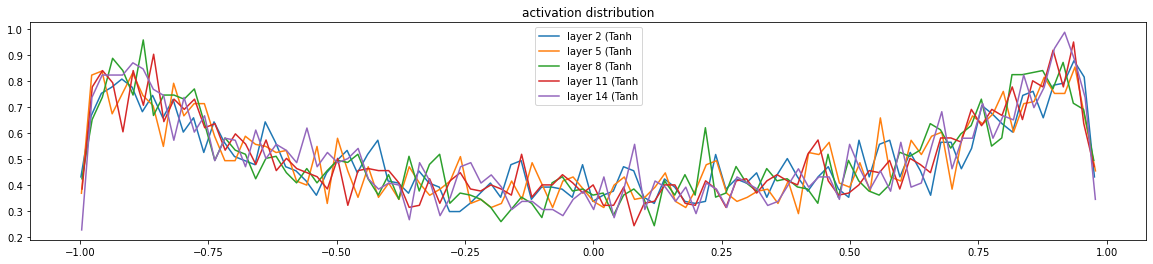

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # dims of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh): # tanh easy to visualize
        t  = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
        

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

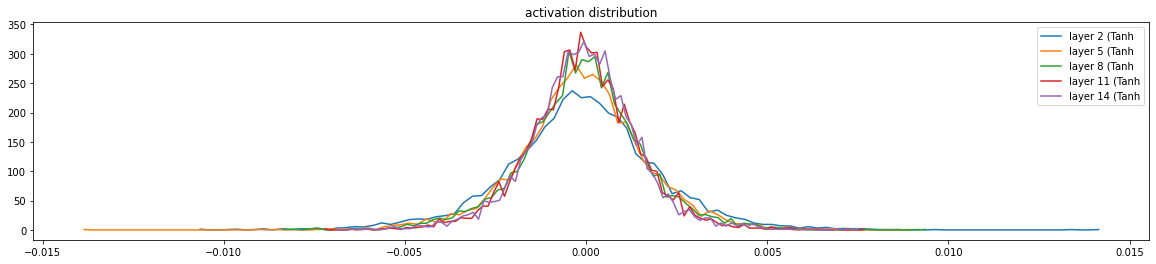

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # dims of plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh): # tanh easy to visualize
        t  = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
        

TypeError: Invalid shape (100,) for image data

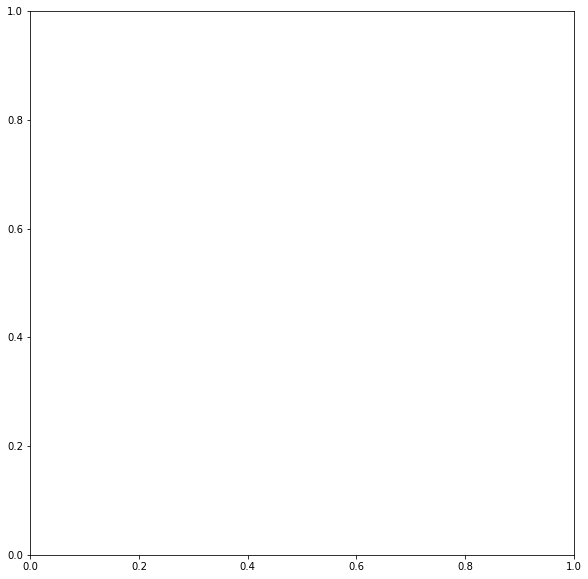

In [24]:
plt.figure(figsize=(20,10))
# white if activation > 0.99
# if entire column white, dead neuron
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [20]:
plt.hist(h_preact.view(-1).tolist(),50); # very active tanh

NameError: name 'h_preact' is not defined

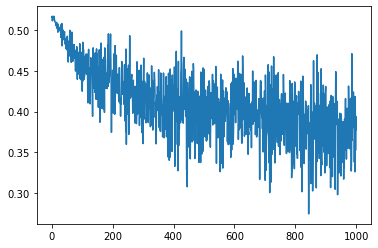

In [21]:
plt.plot(lossi)

In [22]:
# split evaluation
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    emb = C[X_val] # (N, block_size, n_embd)
    h_preact = emb.view(emb.shape[0], -1) @ W1 + b1
    h_preact = (h_preact - h_preact.mean(0, keepdim=True))/h_preact.std(0, keepdim=True)
    h_preact = bngain * h_preact + bnbias
    h = torch.tanh(h_preact) 
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, Y_val) 
    print(split, loss.item())    
split_loss('train')
split_loss('val')

NameError: name 'W1' is not defined

In [23]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass through nn
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print word

NameError: name 'W1' is not defined